# Alternative Classifier - XGBoost

As an alternative model for predicting default risk, we utilized XGBoost,  a powerful gradient boosting algorithm which offers superior predictive accuracy in credit risk modeling due to its ability to handle complex relationships in data and mitigate overfitting. XGBoost excels in achieving high predictive accuracy and is much less prone to overfitting compared to traditional models.

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()[:-18])
from source.eda_utils import get_dataFrame_withShortCols, data_cleaner, preprocess_data
from source.ml_utils import calculate_non_correlated_features, print_results, plot_roc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb

pd.options.mode.chained_assignment = None

In [2]:
# preprocessed data 
train_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('development_sample.csv')))
val_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('testing_sample.csv')))

## Model

In [3]:
selected_features = calculate_non_correlated_features(train_data, 0.60)

In [4]:
X_train, X_val = train_data[selected_features], val_data[selected_features]
y_train = train_data['Default indicator']
y_val = val_data['Default indicator']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In case of xgboost we decided to adjust weiht of minority class rather than oversample. After some experiments 35 came out to be most optimal.

In [11]:
# adjust hyper parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'merror',
    'eta': 0.05, 
    'max_depth': 5,  
    'min_child_weight': 20,  
    'subsample': 0.8, 
    'colsample_bytree': 0.8,  
    'scale_pos_weight': 35,  # weight of minority class
    'gamma': 0,  
    'lambda': 0,  
    'alpha': 0,  
    'seed': 42, 
    'max_delta_step': 1,
}


dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled)
xgb_model = xgb.train(params, dtrain)
y_pred_prob = xgb_model.predict(dval)
fpr, tpr, thresholds = roc_curve(y_val, (y_pred_prob > 0.5).astype(int))


## Results

In [13]:
print_results(y_val, y_pred)

Accuracy: 1.0
Confusion Matrix:
[[3427    0]
 [   0  119]]


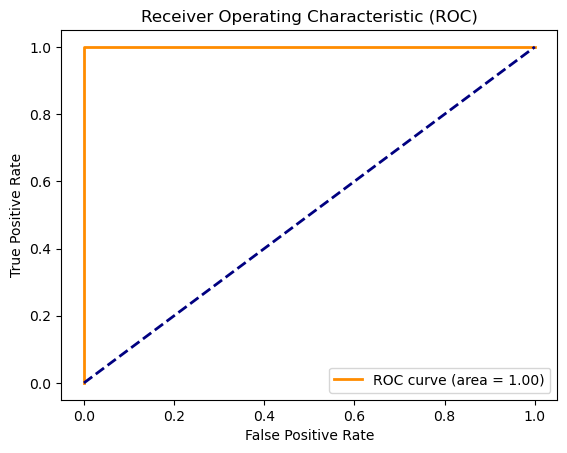

In [12]:
# roc on test data
plot_roc(fpr, tpr)

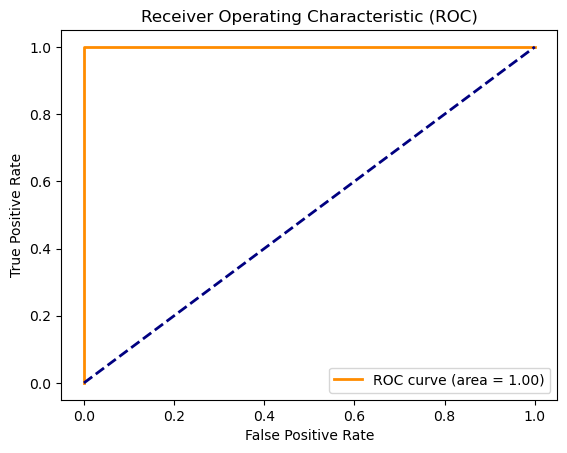

In [8]:
# roc on training data
y_pred_prob = xgb_model.predict(dtrain)
y_pred = (y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
plot_roc(fpr, tpr)

In the confusion matrix and ROC curve, it's evident that XGBoost performed flawlessly in identifying individuals who defaulted. Its results seem suspiciously "too good to be true," raising our suspicions, but we were unable to identify any errors. On the test data, it achieves perfect accuracy, precision, recall (as seen in the confusion matrix without calculations), and an AUC equal to 1. Comparing the results, XGBoost significantly outperformed logistic regression.

## Comparison (Challenges, Limitations etc)

Logistic regression:
- faces challenges in interpreting coefficients and handling nonlinear relationships
- relies on linearity assumptions and may struggle with feature engineering

XGBoost: 
- requires tuning complex hyperparameters and may lack interpretability due to its black-box nature
- demands large datasets and is susceptible to overfitting

Both methods have their strengths and limitations, with logistic regression offering simplicity but limited flexibility, and XGBoost providing superior predictive performance at the cost of increased complexity and potential interpretability issues. In the end, in risk modeling, it is crucial to monitor the model and make decisions based on changes in its outcomes, etc. Some models perform well for a period, but then, for example, due to changes in the environment, they lose effectiveness.